In [6]:
import os
import sys
import torch
import librosa
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt

# Get the current working directory
current_dir = os.getcwd()

# Assuming the structure is LAM/datasets, navigate to the parent directory (LAM)
base_dir = os.path.dirname(current_dir)

# Add the base directory (LAM) to the system path
sys.path.insert(0, base_dir)

from trainer.utils import draw_map, get_field
from dataset.gen_dataset.gen_dataset import get_visibility_matrix


# METU RIRs
Note: used for RIR selection (hover on rirs to define the RIR of interest)

In [7]:
import math 
import plotly.graph_objects as go

def az_ele_from_source(ref_point, src_point):
    """
    Calculates the azimuth and elevation between a reference point and a source point in 3D space.
    Args:
    ref_point (list): A list of three floats representing the x, y, and z coordinates of the reference point.
    src_point (list): A list of three floats representing the x, y, and z coordinates of the other point.
    Returns:
    A tuple of two floats representing the azimuth and elevation angles in degrees plus the distance between the reference and source points.
    """
    dx = src_point[0] - ref_point[0]
    dy = src_point[1] - ref_point[1]
    dz = src_point[2] - ref_point[2]

    azimuth = math.degrees(math.atan2(dy, dx))
    distance = math.sqrt(dx ** 2 + dy ** 2 + dz ** 2)
    elevation = math.degrees(math.asin(dz / distance))
    return azimuth, elevation, distance

def get_mic_xyz():
  """
  Get em32 microphone coordinates in 3D space
  """
  return [(3 - 3) * 0.5, (3 - 3) * 0.5, (2 - 2) * 0.3 + 1.5]

def plot_points_in_room(source_coords, labels):
    # Extract x, y, z coordinates
    x_coords = [coord[0] for coord in source_coords]
    y_coords = [coord[1] for coord in source_coords]
    z_coords = [coord[2] for coord in source_coords]

    # Create a 3D scatter plot
    fig = go.Figure(data=[go.Scatter3d(
        x=x_coords, 
        y=y_coords, 
        z=z_coords, 
        mode='markers',
        marker=dict(size=5, color='red'),
        text=labels,  # Add labels to hover data
        hoverinfo='text'
    )])

    # Set plot labels
    fig.update_layout(
        scene=dict(
            xaxis_title='X Coordinate',
            yaxis_title='Y Coordinate',
            zaxis_title='Z Coordinate'
        ),
        title='3D Plot of Points in Room'
    )

    fig.show()

# Reference METU outter trajectory:  bottom outter trajectory
REF_OUT_TRAJ = ["034", "024", "014", "004", "104", "204",
                        "304", "404", "504", "604", "614", "624",
                        "634", "644", "654", "664", "564", "464",
                        "364", "264", "164", "064", "054", "044"]

top_height = 5
source_coords, rirs = [], []
sources_xyz = []
mic_xyz = get_mic_xyz()

labels = [f"{num[0]}{num[1]}{str(4-(int(num[2])-height))}" for height in range(top_height) for num in REF_OUT_TRAJ]

rir_id = 0
# Outter trajectory: bottom to top
for height in range(0, top_height):
    for num in REF_OUT_TRAJ:
        # Coords computed based on documentation.pdf from METU Sparg
        x = (3 - int(num[0])) * 0.5
        y = (3 - int(num[1])) * 0.5
        z = (2 - (int(num[2])-height)) * 0.3 + 1.5
        source_xyz = [x, y, z] # note -1 since METU is flipped up-side-down
        sources_xyz.append((x, y, z))
        azim, elev, _ = az_ele_from_source(mic_xyz, source_xyz)
        elev *= -1 # Account for elevation being swapped in METU
        source_coords.append((rir_id, azim, elev))

plot_points_in_room(sources_xyz, labels)


# Spatialize Audio on a set of METU RIRs

In [86]:
METU_DATASET = "/scratch/ssd1/RIR_datasets/spargair/em32/"
rirs_list = ["363", "063"] #"362", "262"]
aud_fmt = "em32" # audio format: em32, mic
FS = 24000 # sampling rate
duration = 2 # sythesis duration
num_chans = 32 # get number of channels from RIR

conv_sig = np.zeros((FS * duration, num_chans))

for rir_tokens in rirs_list:
    rir_name = rir_tokens[0] + rir_tokens[1] + rir_tokens[2]
    ir_path = os.path.join(METU_DATASET, rir_name, f"IR_{aud_fmt}.wav")
    irdata, sr = librosa.load(ir_path, mono=False, sr=FS)
    
    rir_sig = irdata.T
    
    noise = np.random.normal(0, 1, FS * duration) # generate noise
    
    for ichan in range(num_chans):
        conv_sig[:, ichan] += np.convolve(noise, rir_sig[:FS, ichan], mode='same')
    

# Generate visibility matrix from audio 

In [87]:
clip_name = "/scratch/data/repos/LAM/dataset/simulated/arni_eval_output_vardur_poly2_maxdur2s/095_polyphony2_8_146_0_8_18_21.wav"
T_sti = 10e-3 # 100ms audio frames
# fs, eigen_sig = wavfile.read(clip_name)
# print(eigen_sig.shape)
vsg_sig, apgd = get_visibility_matrix(conv_sig, FS, apgd=True, bands=[3], T_sti=T_sti) # visibility graph matrix 32ch 

In [77]:
# APGD Map Dimensions (axis, num_frames, num_pixels)
print(apgd[0, ].shape)

(20, 484)


# Generate acoustic map visualization

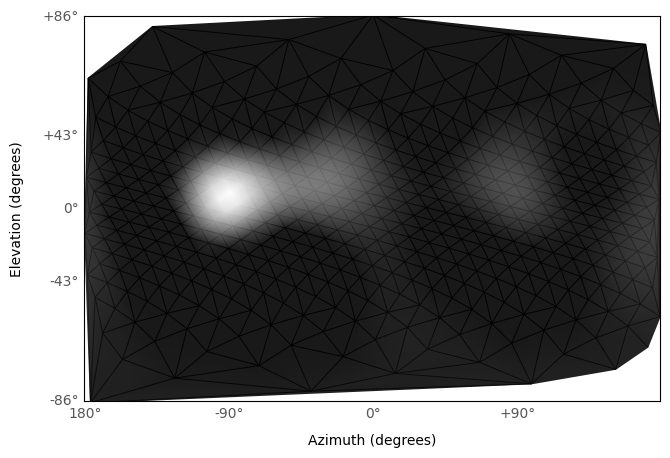

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
R_field = get_field()
arg_lonticks = np.linspace(-180, 180, 5)
apgd_map = np.abs(apgd[0, 0])
apgd_map /= apgd_map.max()
apgd_map = np.tile(apgd_map, (3, 1))
fig2, ax2, triangulation2 = draw_map(apgd_map, R_field,
        lon_ticks=arg_lonticks,
        catalog=None,
        show_labels=True,
        show_axis=True,
        fig=fig,
        ax=ax)